# Geodata cleaning

data downloaded on 07/04/2022 from
https://data.spatialhub.scot/dataset/community_council_boundaries-is

councils and NHS boards matched using
https://en.wikipedia.org/wiki/NHS_Scotland

## Ethical/privacy issues

This geographical data was provided by the company Improvement Sources:
"The Spatial Hub collects together data on a whole host of topics from local authorities and other partner organisations, transforms and joins it all together to form Scotland-wide datasets and publishes them in different ways for the rest of the data community to access and use."

In [2]:
import os
import pandas as pd
import geopandas as gpd
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
plt.rcParams['figure.dpi'] = 200

In [3]:
def compress_shape_data():
    # load the shape files
    raw_data = gpd.read_file(os.path.join(os.getcwd(), 'data', 'council_boundaries.shp'))

    # merge polygons by council
    data = raw_data.dissolve(by='local_auth')

    # drop redundant columns
    data = data.drop(columns=['cc_name', 'active', 'url', 'sh_date_up', 'sh_src', 'sh_src_id', 'la_s_code']).reset_index()

    # save into new shape file
    data.to_file(os.path.join(os.getcwd(), 'data', 'council_boundaries_small.shp'))

# Loading data & functions

In [4]:
# functions copied from main
def format_graph(ax, /, *, mode='y', xlabel='', ylabel='', title=''):
    # graphs with multiple years
    if mode == 'y':
        # creates proper x-axis ticks formatting
        ax.set_xticks(ax.get_xticks()[::12])
        ax.set_xticklabels([f'20{str(s).zfill(2)}' if not s % 2 else '' for s in range(7, 22)])

    # graphs within 1 year
    elif mode == 'm':
        ax.set_xticks([m for m in range(12)])
        ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

    # graph labels
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # set title
    ax.set_title(title)

def get_raw_data():
    return pd.read_csv(os.path.join(os.getcwd(), 'data', 'ae_activity_waiting_times_feb2022-data.csv'))

def get_data():
    raw_data = get_raw_data()

    # split date into month and year columns
    dates = raw_data['Data_Month_Date'].apply(lambda s: tuple(s.split(sep='-'))).apply(pd.Series)
    dates.columns = ['month', 'year']

    # drop duplicate columns
    data = dates.join(raw_data).drop(columns=['Data_Month_Date', 'Country',
                                              'Number_of_Attendances_Epi', 'Number_Meeting_Target_epi'])

    # rename columns
    data = data.rename(columns={'Number_Of_Attendances_agg':'total',
                                'Number_Meeting_Target_agg':'under4h',
                                'Attendance_greater_8hrs':'under12h',
                                'Attendances_greater_12hrs':'over12h',
                                'Discharge_destination_admission_to_same':'discharge_same',
                                'Discharge_destination_residence':'discharge_residence',
                                'Discharge_destination_transfer':'discharge_transfer',
                                'Discharge_destination_other_spec':'discharge_other',
                                'Discharge_destination_unknown':'discharge_unknown',
                                'HB_Treatment_Description':'area',
                                'Treatment_Location_Code':'location_code',
                                'Treatment_Location_Name':'location_name',
                                'ED_MIU':'type'})

    # calculate 4-8h column
    data['under8h'] = data['total'] - (data['under4h'] + data['under12h'] + data['over12h'])

    # rearrange columns
    cols = data.columns.tolist()
    data = data[cols[:8] + [cols[-1]] + cols[-3:-1] + cols[8:-3]]

    # month to numeric
    data['month'] = data['month'].apply(lambda s: {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6,
                                                   'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}[s])
    # year to integers
    data['year'] = data['year'].apply(int)

    # make year-month column
    data['year_month'] = data['year'].apply(lambda s: str(s).zfill(2)) + \
                         data['month'].apply(lambda s: str(s).zfill(2))

    # calculate compliance
    data['compliance'] = data['total'] * 0.95 <= data['under4h']
    data['compliance_frac'] = data['under4h'] / data['total']

    return data

In [89]:
# load hospital data
nhs_data = get_data()
nhs_data = nhs_data.groupby(['year', 'area']).mean()\
                   .sort_values(['area', 'year']).reset_index()
nhs_data

,year,area,month,total,under4h,under8h,under12h,over12h,discharge_same,discharge_other,discharge_residence,discharge_transfer,discharge_unknown,compliance,compliance_frac
0,7,NHS Ayrshire & Arran,9.666667,2002.037037,1950.259259,110.083333,4.000000,2.416667,1532.583333,4.500000,2687.500000,50.750000,82.583333,1.000000,0.987217
1,8,NHS Ayrshire & Arran,6.500000,1852.900000,1825.200000,67.958333,1.125000,0.166667,1619.250000,3.958333,2607.458333,72.250000,146.625000,1.000000,0.993596
2,9,NHS Ayrshire & Arran,6.500000,1875.216667,1839.916667,86.250000,1.958333,0.041667,1669.458333,7.625000,2669.958333,61.541667,104.000000,0.983333,0.991766
3,10,NHS Ayrshire & Arran,6.500000,1912.800000,1862.683333,121.791667,3.250000,0.250000,1707.333333,6.833333,2671.708333,83.208333,132.000000,0.966667,0.988960
4,11,NHS Ayrshire & Arran,6.500000,1973.216667,1894.333333,190.291667,6.083333,0.500000,1798.583333,5.791667,2475.000000,128.583333,338.666667,0.850000,0.981611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,17,NHS Western Isles,6.500000,247.416667,245.805556,2.416667,0.000000,0.000000,75.250000,0.375000,257.958333,4.916667,5.000000,1.000000,0.996213
206,18,NHS Western Isles,6.500000,259.250000,256.250000,4.458333,0.041667,0.000000,83.916667,0.250000,264.041667,5.583333,6.708333,1.000000,0.994128
207,19,NHS Western Isles,6.500000,264.916667,261.305556,5.291667,0.125000,0.000000,85.833333,0.125000,268.791667,3.541667,6.666667,1.000000,0.993346
208,20,NHS Western Isles,6.500000,167.472222,164.361111,4.583333,0.083333,0.000000,60.875000,0.166667,166.750000,1.625000,3.250000,1.000000,0.990210


In [91]:
# create slope for monthly change in fractional compliance per NHS board
ols_data = pd.DataFrame(
    [(area,
      smf.ols('compliance_frac ~ year',
              data=nhs_data[(nhs_data['area'] == area) &
                            (nhs_data['year'] < 20)]
              ).fit().params[1])
     for area in nhs_data['area'].unique()],
    columns=['area', 'ols_compliance_frac'],
).set_index('area')
ols_data

,ols_compliance_frac
area,
NHS Ayrshire & Arran,-0.003667
NHS Borders,-0.001107
NHS Dumfries & Galloway,-0.001692
NHS Fife,0.000142
NHS Forth Valley,-0.004476
NHS Grampian,-0.000632
NHS Greater Glasgow & Clyde,-0.005239
NHS Highland,-0.000470
NHS Lanarkshire,-0.005125


In [ ]:
# load polygons and match NHS boards to councils
geodata = gpd.read_file(os.path.join(os.getcwd(), 'data', 'council_boundaries_small.shp'))
geodata['area'] = pd.Series([
    'NHS Grampian', 'NHS Grampian', 'NHS Tayside', 'NHS Highland', 'NHS Lothian', 'NHS Forth Valley',
    'NHS Dumfries & Galloway', 'NHS Tayside', 'NHS Ayrshire & Arran', 'NHS Greater Glasgow & Clyde',
    'NHS Lothian', 'NHS Greater Glasgow & Clyde', 'NHS Western Isles', 'NHS Forth Valley', 'NHS Fife',
    'NHS Greater Glasgow & Clyde', 'NHS Highland', 'NHS Greater Glasgow & Clyde', 'NHS Lothian',
    'NHS Grampian', 'NHS Ayrshire & Arran', 'NHS Lanarkshire', 'NHS Orkney', 'NHS Tayside',
    'NHS Greater Glasgow & Clyde', 'NHS Borders', 'NHS Shetland', 'NHS Ayrshire & Arran', 'NHS Lanarkshire',
    'NHS Forth Valley', 'NHS Greater Glasgow & Clyde', 'NHS Lothian'
])
geodata = geodata.dissolve(by='area').drop(columns=['local_auth'])
geodata

In [94]:
df = nhs_data.groupby(['area', 'year']).mean().reset_index()
diff_data = pd.DataFrame(
    [(area,
      (float(df[(df['area'] == area) & (df['year'] == 18)]['compliance_frac']) +        # 2008/09 to 2018/19 diff
       float(df[(df['area'] == area) & (df['year'] == 19)]['compliance_frac'])) / 2-
      (float(df[(df['area'] == area) & (df['year'] == 8)]['compliance_frac']) +
       float(df[(df['area'] == area) & (df['year'] == 9)]['compliance_frac'])) / 2,
      (float(df[(df['area'] == area) & (df['year'] == 8)]['compliance_frac']) +         # 2008/09 value
       float(df[(df['area'] == area) & (df['year'] == 9)]['compliance_frac'])) / 2,
      (float(df[(df['area'] == area) & (df['year'] == 19)]['compliance_frac']) +        # 2018/19 value
       float(df[(df['area'] == area) & (df['year'] == 19)]['compliance_frac'])) / 2)
     for area in df['area'].unique()],
    columns=['area', 'diff_compliance_frac', 'compliance_frac_08', 'compliance_frac_19']
).set_index('area')
diff_data

,diff_compliance_frac,compliance_frac_08,compliance_frac_19
area,,,
NHS Ayrshire & Arran,-0.043285,0.992681,0.935232
NHS Borders,-0.011946,0.995459,0.983225
NHS Dumfries & Galloway,-0.021952,0.992191,0.968416
NHS Fife,-0.002939,0.982389,0.975153
NHS Forth Valley,-0.064880,0.979055,0.929088
NHS Grampian,-0.005978,0.993180,0.985396
NHS Greater Glasgow & Clyde,-0.063619,0.979777,0.902475
NHS Highland,-0.005091,0.989432,0.981897
NHS Lanarkshire,-0.057614,0.986834,0.913813


In [95]:
# merge datasets
data = geodata.join(nhs_data.groupby('area').mean()).join(ols_data).join(diff_data).reset_index()
data

,area,geometry,year,month,total,under4h,under8h,under12h,over12h,discharge_same,discharge_other,discharge_residence,discharge_transfer,discharge_unknown,compliance,compliance_frac,ols_compliance_frac,diff_compliance_frac,compliance_frac_08,compliance_frac_19
0,NHS Ayrshire & Arran,"MULTIPOLYGON (((201987.500 600410.100, 201992....",14.0,6.711111,1906.650247,1773.238395,239.355556,66.511111,25.602778,1646.161111,6.463889,2654.458333,87.419444,161.897222,0.761111,0.965562,-0.003667,-0.043285,0.992681,0.935232
1,NHS Borders,"POLYGON ((356608.300 589933.300, 356613.900 58...",14.0,6.577429,546.786095,505.797841,111.083333,17.155556,7.166667,738.655556,3.322222,1217.327778,155.472222,67.244444,0.890540,0.982099,-0.001107,-0.011946,0.995459,0.983225
2,NHS Dumfries & Galloway,"POLYGON ((247804.000 539058.000, 247697.000 53...",14.0,6.616491,769.071978,719.041770,81.631474,5.279534,0.558860,441.162156,1.963725,1097.756116,38.758992,19.812831,0.791461,0.974571,-0.001692,-0.021952,0.992191,0.968416
3,NHS Fife,"MULTIPOLYGON (((329747.860 681969.410, 329732....",14.0,6.692517,1810.298384,1712.569218,131.507333,16.896492,3.119167,556.515913,13.214746,2133.515040,84.318127,67.174421,0.823866,0.977676,0.000142,-0.002939,0.982389,0.975153
4,NHS Forth Valley,"POLYGON ((288751.500 669383.220, 288751.230 66...",14.0,6.702564,3160.212179,2908.976496,224.965171,22.280556,3.989957,647.897222,4.540598,1963.617094,68.995299,475.161966,0.619231,0.949193,-0.004476,-0.064880,0.979055,0.929088
5,NHS Grampian,"POLYGON ((396287.580 813554.900, 396286.980 81...",14.0,6.617068,754.603647,711.217113,150.398704,11.714722,1.363981,610.072500,5.695833,1777.322222,20.508519,90.700463,0.911091,0.985916,-0.000632,-0.005978,0.993180,0.985396
6,NHS Greater Glasgow & Clyde,"POLYGON ((251696.130 648553.250, 251695.500 64...",14.0,6.679699,3966.471818,3656.139243,283.649555,24.242969,2.440051,992.265627,6.517312,2546.158931,82.036671,339.493276,0.612990,0.942293,-0.005239,-0.063619,0.979777,0.902475
7,NHS Highland,"MULTIPOLYGON (((116344.350 651847.650, 116338....",14.0,6.700751,430.015236,416.559242,58.739552,3.692716,0.426173,345.278318,6.583225,1171.646636,6.925664,8.966867,0.936866,0.986063,-0.000470,-0.005091,0.989432,0.981897
8,NHS Lanarkshire,"POLYGON ((271546.750 635000.000, 271515.420 63...",14.0,6.654264,3469.087003,3142.103506,368.311936,57.431488,13.534994,1443.294137,6.852636,3560.372810,105.643331,48.526920,0.583953,0.939303,-0.005125,-0.057614,0.986834,0.913813
9,NHS Lothian,"MULTIPOLYGON (((326214.000 655263.300, 326121....",14.0,6.680729,4033.156603,3676.537338,363.290778,64.827333,17.828833,1342.928000,5.707111,3720.166389,94.645333,12.606444,0.585410,0.940661,-0.006257,-0.084986,0.983828,0.905826


# Plots

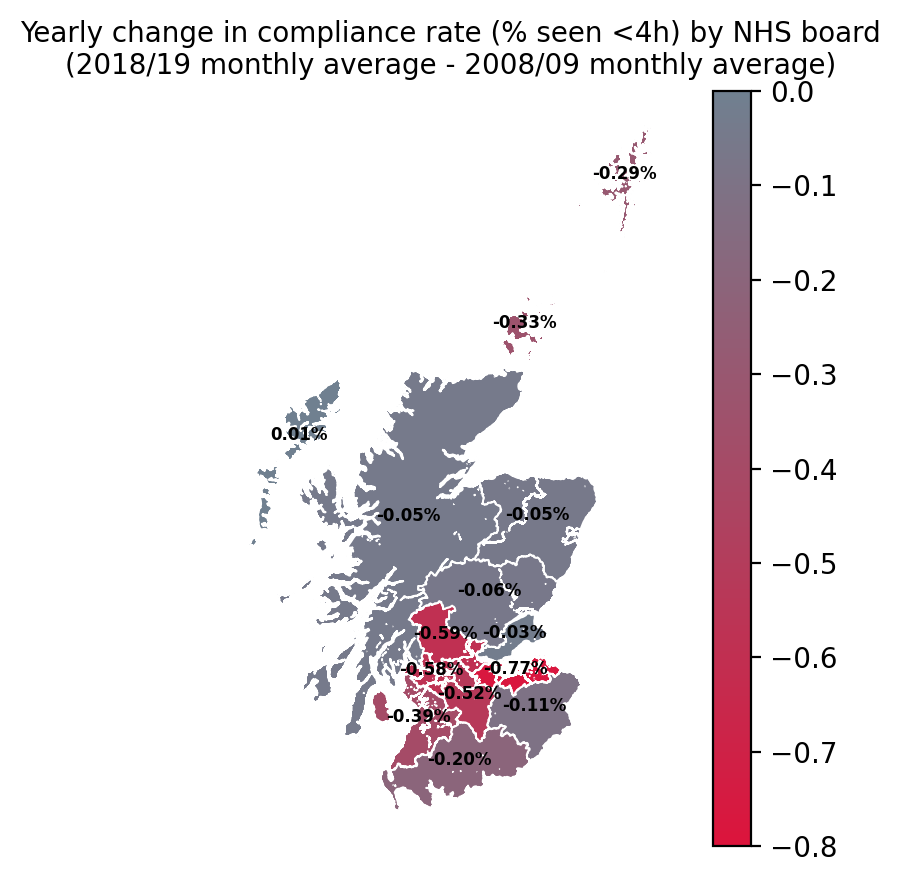

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
cmap = sns.blend_palette(['crimson', 'slategray'], as_cmap=True)
norm = plt.Normalize(vmin=-0.8, vmax=0)

data.plot(column=data['diff_compliance_frac'] * 100 / 11,
          cmap=cmap,
          norm=norm,
          linewidth=.7,
          edgecolor='white',
          ax=ax)

# set labels
ax.axis('off')
ax.set_title('Yearly change in compliance rate (% seen <4h) by NHS board\n'
             '(2018/19 monthly average - 2008/09 monthly average)',
             fontsize=10)

# add color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm)

# plot values on top of graph
for _, row in data.iterrows():
    x, y = row['geometry'].centroid.coords[0]
    val = row['diff_compliance_frac'] * 100 / 11
    plt.text(s=f'{val:.2f}%',
             x=x,
             y=y,
             horizontalalignment='center',
             fontdict={'weight':'bold', 'size':6})

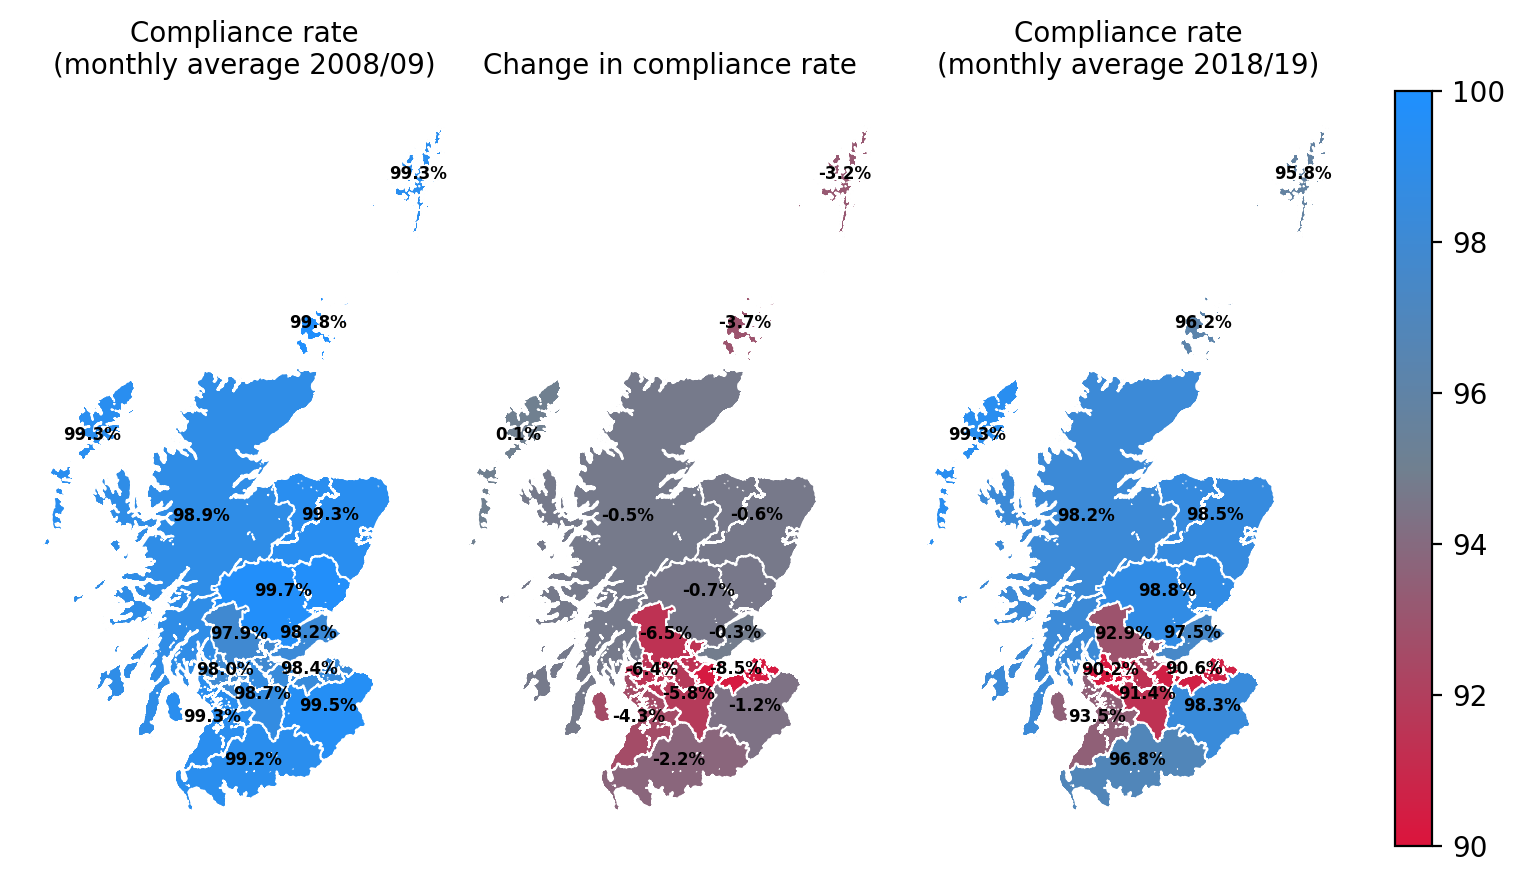

In [105]:
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11, 5))
fig = plt.figure(figsize=(11, 5))
gs = plt.GridSpec(1, 3, wspace=-0.5)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])

# middle graph (delta)
cmap1 = sns.blend_palette(['crimson', 'slategray'], as_cmap=True)
norm1 = plt.Normalize(vmin=-9, vmax=0)
data.plot(column=data['diff_compliance_frac'] * 100,
          cmap=cmap1,
          norm=norm1,
          linewidth=.7,
          edgecolor='white',
          ax=ax2)
ax2.axis('off')
ax2.set_title('Change in compliance rate',
             fontsize=10)
for _, row in data.iterrows():
    x, y = row['geometry'].centroid.coords[0]
    val = row['diff_compliance_frac'] * 100
    ax2.text(s=f'{val:.1f}%',
             x=x,
             y=y,
             horizontalalignment='center',
             fontdict={'weight':'bold', 'size':6})

# left & right plots (2008 and 2019)
cmap2 = sns.blend_palette(['crimson', 'slategray', 'dodgerblue'], as_cmap=True)
norm2 = TwoSlopeNorm(vmin=90,
                     vmax=100,
                     vcenter=95)
data.plot(column=data['compliance_frac_08'] * 100,
          cmap=cmap2,
          norm=norm2,
          linewidth=.7,
          edgecolor='white',
          ax=ax1)
ax1.axis('off')
ax1.set_title('Compliance rate\n(monthly average 2008/09)',
             fontsize=10)
for _, row in data.iterrows():
    x, y = row['geometry'].centroid.coords[0]
    val = row['compliance_frac_08'] * 100
    ax1.text(s=f'{val:.1f}%',
             x=x,
             y=y,
             horizontalalignment='center',
             fontdict={'weight':'bold', 'size':6})

data.plot(column=data['compliance_frac_19'] * 100,
          cmap=cmap2,
          norm=norm2,
          linewidth=.7,
          edgecolor='white',
          ax=ax3)
ax3.axis('off')
ax3.set_title('Compliance rate\n(monthly average 2018/19)',
              fontsize=10)
sm = plt.cm.ScalarMappable(cmap=cmap2, norm=norm2)
cbar = fig.colorbar(sm)
for _, row in data.iterrows():
    x, y = row['geometry'].centroid.coords[0]
    val = row['compliance_frac_19'] * 100
    ax3.text(s=f'{val:.1f}%',
             x=x,
             y=y,
             horizontalalignment='center',
             fontdict={'weight':'bold', 'size':6})

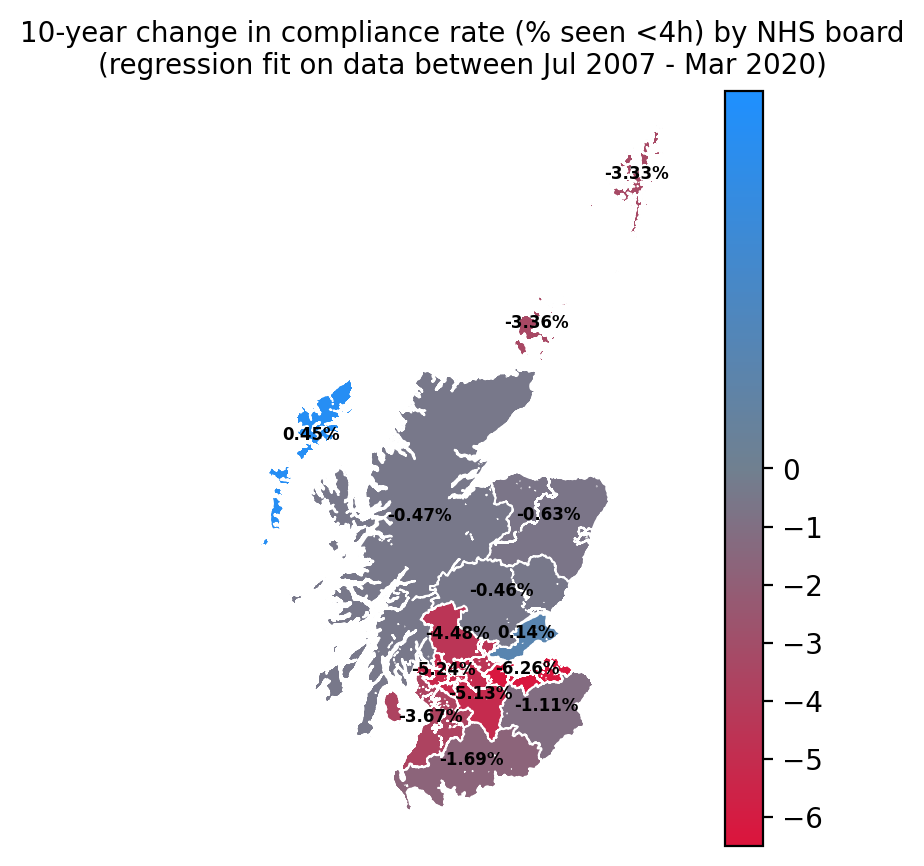

In [104]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
cmap = sns.blend_palette(['crimson', 'slategray', 'dodgerblue'], as_cmap=True)
norm = TwoSlopeNorm(vmin=-6.5, vmax=0.5, vcenter=0)

data.plot(column=data['ols_compliance_frac'] * 1000,
          cmap=cmap,
          norm=norm,
          linewidth=.7,
          edgecolor='white',
          ax=ax)

# set labels
ax.axis('off')
ax.set_title('10-year change in compliance rate (% seen <4h) by NHS board\n'
             '(regression fit on data between Jul 2007 - Mar 2020)',
             fontsize=10)

# add color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm)

# plot values on top of graph
for _, row in data.iterrows():
    x, y = row['geometry'].centroid.coords[0]
    val = row['ols_compliance_frac'] * 1000
    plt.text(s=f'{val:.2f}%',
             x=x,
             y=y,
             horizontalalignment='center',
             fontdict={'weight':'bold', 'size':6})

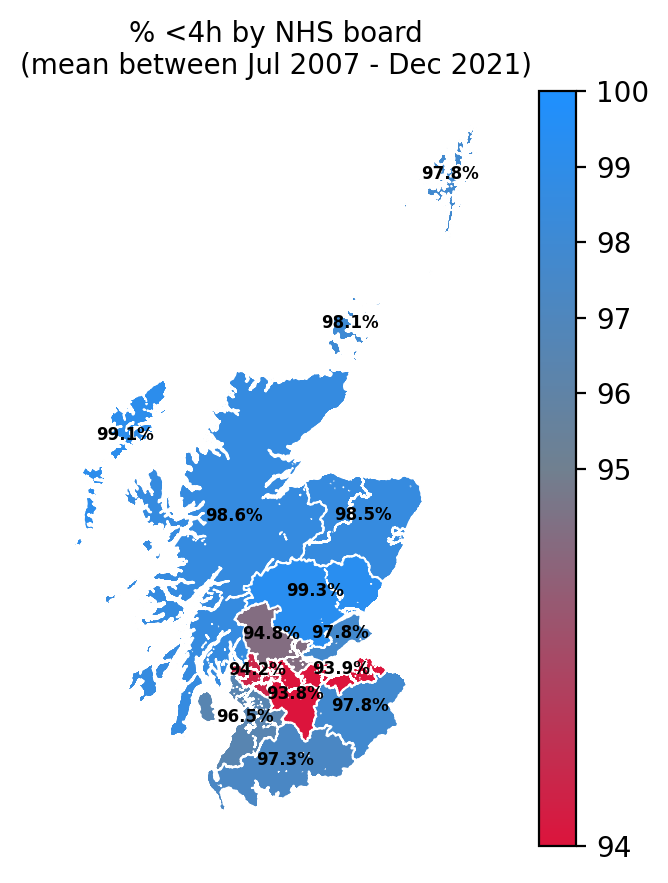

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
cmap = sns.blend_palette(['crimson', 'slategray', 'dodgerblue'], as_cmap=True)
norm = TwoSlopeNorm(vmin=94,
                    vmax=100,
                    vcenter=95)

data.plot(column=data['compliance_frac'] * 100,
          cmap=cmap,
          norm=norm,
          linewidth=.7,
          edgecolor='white',
          ax=ax)

# set labels
ax.axis('off')
ax.set_title('% <4h by NHS board\n(mean between Jul 2007 - Dec 2021)',
             fontsize=10)

# add color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm)

# plot values on top of graph
for _, row in data.iterrows():
    x, y = row['geometry'].centroid.coords[0]
    val = row['compliance_frac'] * 100
    plt.text(s=f'{val:.1f}%',
             x=x,
             y=y,
             horizontalalignment='center',
             fontdict={'weight':'bold', 'size':6})

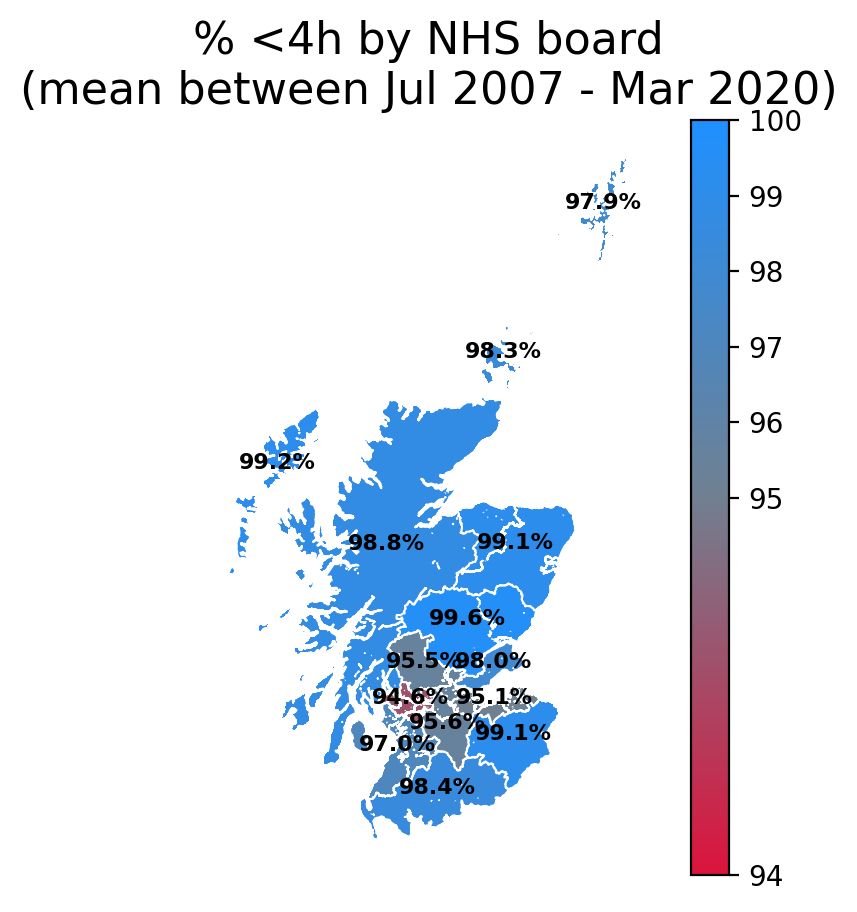

In [31]:
df = geodata.join(nhs_data[nhs_data['year_month'] < '2003'].groupby('area').mean()).reset_index()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
cmap = sns.blend_palette(['crimson', 'slategray', 'dodgerblue'], as_cmap=True)
norm = TwoSlopeNorm(vmin=94,
                    vmax=100,
                    vcenter=95)

df.plot(column=df['compliance_frac'] * 100,
        cmap=cmap,
        norm=norm,
        linewidth=.7,
        edgecolor='white',
        ax=ax)

# set labels
ax.axis('off')
ax.set_title('% <4h by NHS board\n(mean between Jul 2007 - Mar 2020)',
             fontsize=16)

# add color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm)

# plot values on top of graph
for _, row in df.iterrows():
    x, y = row['geometry'].centroid.coords[0]
    val = row['compliance_frac'] * 100
    plt.text(s=f'{val:.1f}%',
             x=x,
             y=y,
             horizontalalignment='center',
             fontdict={'weight':'bold', 'size':8})

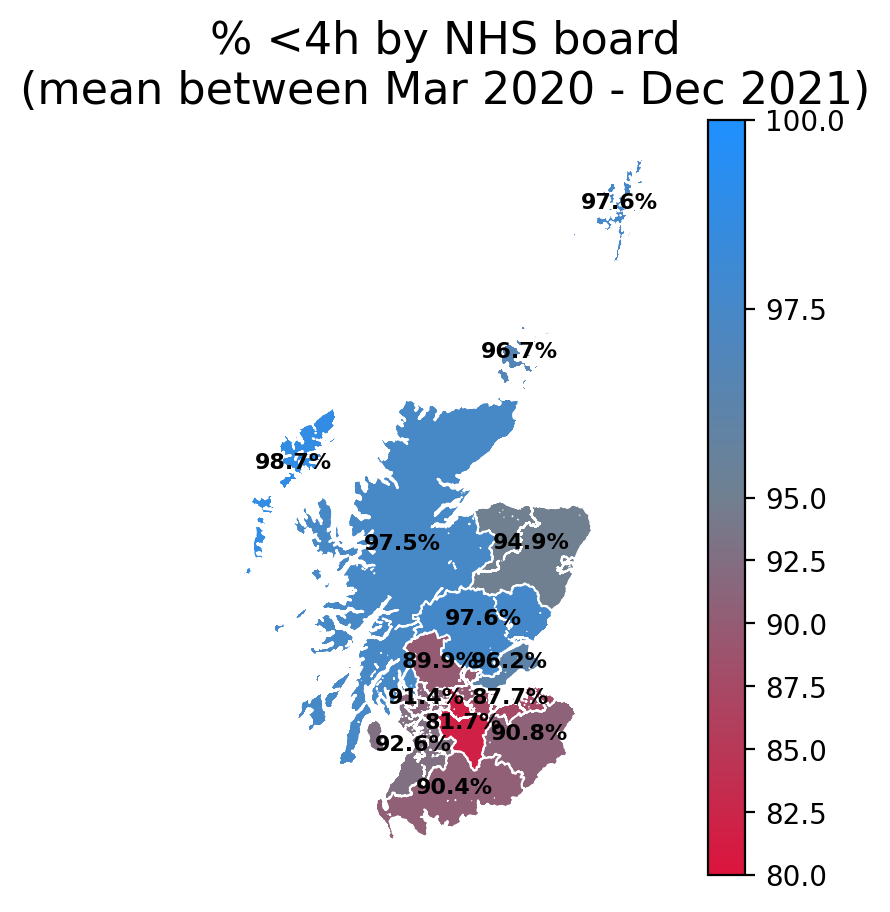

In [32]:
df = geodata.join(nhs_data[nhs_data['year_month'] >= '2003'].groupby('area').mean()).reset_index()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
cmap = sns.blend_palette(['crimson', 'slategray', 'dodgerblue'], as_cmap=True)
norm = TwoSlopeNorm(vmin=80,
                    vmax=100,
                    vcenter=95)

df.plot(column=df['compliance_frac'] * 100,
        cmap=cmap,
        norm=norm,
        linewidth=.7,
        edgecolor='white',
        ax=ax)

# set labels
ax.axis('off')
ax.set_title('% <4h by NHS board\n(mean between Mar 2020 - Dec 2021)',
             fontsize=16)

# add color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm)

# plot values on top of graph
for _, row in df.iterrows():
    x, y = row['geometry'].centroid.coords[0]
    val = row['compliance_frac'] * 100
    plt.text(s=f'{val:.1f}%',
             x=x,
             y=y,
             horizontalalignment='center',
             fontdict={'weight':'bold', 'size':8})

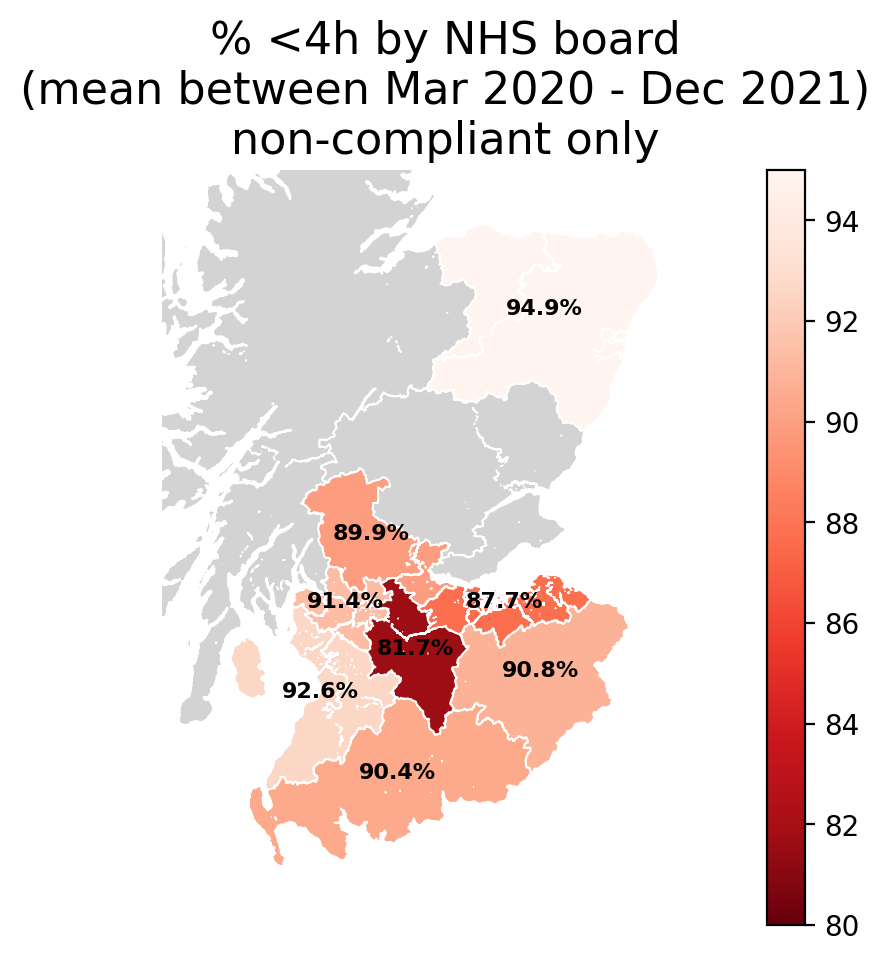

In [33]:
df = geodata.join(nhs_data[nhs_data['year_month'] >= '2003'].groupby('area').mean()).reset_index()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
cmap = 'Reds_r'
norm = plt.Normalize(vmin=round(df['compliance_frac'].min(), 1)*100,
                     vmax=95)

df.plot(facecolor='lightgray',
        linewidth=.7,
        edgecolor='white',
        ax=ax)

df = df[df['compliance_frac'] < 0.95]
df.plot(column=df['compliance_frac'] * 100,
        cmap=cmap,
        norm=norm,
        linewidth=.7,
        edgecolor='white',
        ax=ax)

# set labels & scale axes
ax.axis('off')
ax.set_xlim((150000, 450000))
ax.set_ylim((500000, 900000))
ax.set_title('% <4h by NHS board\n(mean between Mar 2020 - Dec 2021)\nnon-compliant only',
             fontsize=16)

# add color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm)

# plot values on top of graph
for _, row in df.iterrows():
    x, y = row['geometry'].centroid.coords[0]
    val = row['compliance_frac'] * 100
    plt.text(s=f'{val:.1f}%',
             x=x,
             y=y,
             horizontalalignment='center',
             fontdict={'weight':'bold', 'size':8})

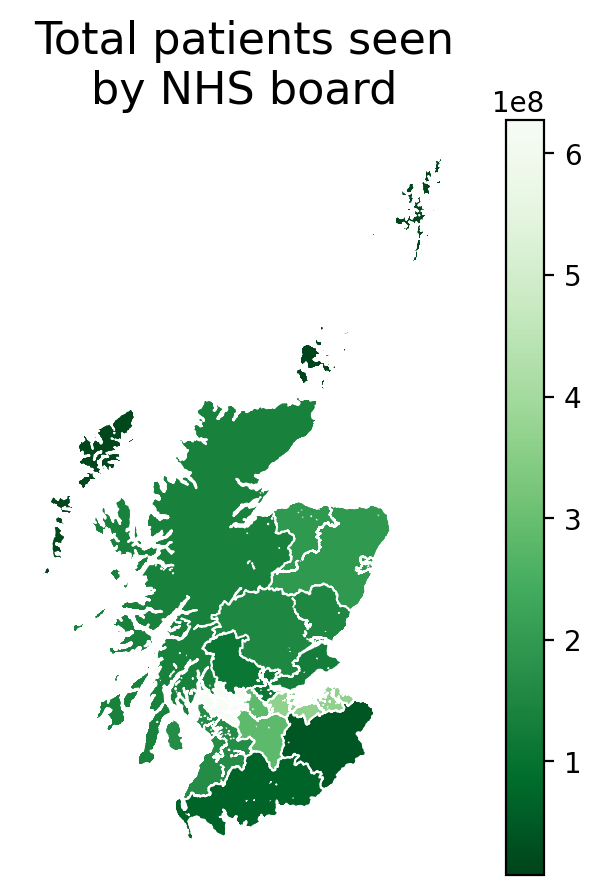

In [34]:
df = geodata.join(nhs_data.groupby('area').sum()).reset_index()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
cmap = 'Greens_r'
norm = plt.Normalize(vmin=round(df['total'].min(), 1)*100,
                     vmax=round(df['total'].max(), 1)*100)

df.plot(column='total',
        cmap=cmap,
        linewidth=.7,
        edgecolor='white',
        ax=ax)

# set labels
ax.axis('off')
ax.set_title('Total patients seen\nby NHS board',
             fontsize=16)

# add color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm)